# Text Generation with Transformers

In this notebook we use the components developed in `modelling.transformer` to train a transformer decoder for our text generation task. We will compare the performance of this model with that established by our RNN baseline.

## Imports

The bulk of the code required to setup, train and generate new text from the model, is contained within `modelling.transformer` (check the source code for the details). We import this module together with others that serve the training data and manage model persistence.

In [1]:
from textwrap import wrap

from torch.utils.data import DataLoader

from modelling import data as data
from modelling import transformer as tfr
from modelling import utils as utils

## Model and Training Parameters

Configure hyper-parameters for the model and the training routine.

In [2]:
MODEL_NAME = "decoder_next_word_gen"

SIZE_EMBED = 256

MAX_EPOCHS = 100
BATCH_SIZE = 64
SEQ_LEN = 40
MIN_WORD_FREQ = 2
MAX_LEARNING_RATE = 0.001
WARMUP_EPOCHS = 2
GRADIENT_CLIP = 5

## Setup Training Data

In [3]:
datasets = data.make_sequence_datasets(seq_len=SEQ_LEN, min_word_freq=MIN_WORD_FREQ)

train_dl = DataLoader(
    datasets.train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    collate_fn=data.pad_seq2seq_data,
)

val_dl = DataLoader(
    datasets.val_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=True,
    collate_fn=data.pad_seq2seq_data,
)

## Instantiate Model

In [4]:
model = tfr.NextWordPredictionTransformer(datasets.tokenizer.vocab_size, SIZE_EMBED)
model

NextWordPredictionTransformer(
  (_position_encoder): PositionalEncoding(
    (_dropout): Dropout(p=0.1, inplace=False)
  )
  (_embedding): Embedding(63217, 256)
  (_decoder): TransformerDecoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
    (multihead_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
    (linear1): Linear(in_features=256, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=512, out_features=256, bias=True)
    (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (norm3): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
    (dropout3): Dropout(p=0.1, inplace=Fal

If we compare this model with the RNN model, then it is easy to see that this one is significantly more complex with many more layers (and thus parameters). We start with the same embedding layer albeit combined with a positional encoding, that is then fed into a transformer decoder layer comprised of two multi-head attention blocks, two linear (dense) feed-forward layers and three sets of layer normalisation and dropout.

## Train

As well as having a far more complex architecture, transformer based models are also trickier to train successfully. In particular, the vast number of parameters can lead to gradients that can grow very large in the early stages of training, thus preventing convergence.

We handle this using a learning rate schedule that starts close to zero and slowly ramps-up, before falling again as we reach the end of the desired number of epochs. We also clip the gradients - see the source code for the full details.

In [5]:
train_losses, val_losses = tfr.train(
    model, train_dl, val_dl, MAX_EPOCHS, MAX_LEARNING_RATE, WARMUP_EPOCHS, GRADIENT_CLIP
)
utils.save_model(model, name=MODEL_NAME, loss=min(train_losses.values()))

number of warmup steps: 1186 / 59300


epoch 9 training loss = 4.8583 (LR = 0.00098015): 100%|██████████| 593/593 [24:54<00:00,  2.52s/it]
epoch 10 training loss = 4.8166 (LR = 0.00097553): 100%|██████████| 593/593 [24:55<00:00,  2.52s/it]
epoch 11 training loss = 4.7851 (LR = 0.00097044): 100%|██████████| 593/593 [24:56<00:00,  2.52s/it]
epoch 12 training loss = 4.7448 (LR = 0.00096489): 100%|██████████| 593/593 [24:55<00:00,  2.52s/it]
epoch 13 training loss = 4.7174 (LR = 0.00095888): 100%|██████████| 593/593 [24:56<00:00,  2.52s/it]
epoch 14 training loss = 4.6850 (LR = 0.00095241): 100%|██████████| 593/593 [24:56<00:00,  2.52s/it]
epoch 15 training loss = 4.6583 (LR = 0.00094550): 100%|██████████| 593/593 [24:58<00:00,  2.53s/it]
epoch 16 training loss = 4.6357 (LR = 0.00093815): 100%|██████████| 593/593 [24:56<00:00,  2.52s/it]
epoch 17 training loss = 4.6127 (LR = 0.00093037): 100%|██████████| 593/593 [24:54<00:00,  2.52s/it]
epoch 18 training loss = 4.5903 (LR = 0.00092216): 100%|██████████| 593/593 [24:54<00:00,  2


best model:
|-- epoch: 1
|-- loss: 5.8860


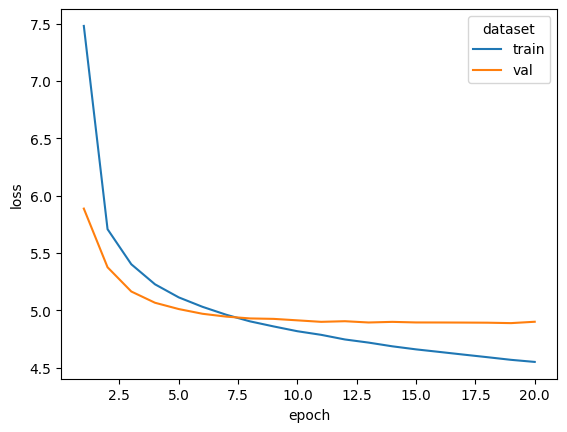

In [6]:
utils.plot_train_losses(train_losses, val_losses)

## Generate Text with Model

Start by loading a model and instantiating a tokenizer that can also map from tokens back to text. The `load_model` function will load the best performing model that has been persisted on the local filesystem.

In [7]:
best_model: tfr.NextWordPredictionTransformer = utils.load_model(MODEL_NAME)

loading .models/decoder_next_word_gen/trained@2023-07-12T10:23:08;loss=4_5489.pt


Now pass a prompt to the model and get it to generate the text that comes after.

In [8]:
prompt = "I thought this movie was interesting, but"
text = tfr.generate(best_model, prompt, datasets.tokenizer, temperature=1.0)

for line in wrap(text, width=89):
    print(line)

==> I THOUGHT THIS MOVIE WAS INTERESTING, BUT it was all about 2 reasons and specially
visual feast on display here look as if you watch me the ending of the film the print it
is really great and the only thing that saves watching was that a...


And compare this output with that from an untrained model.

In [9]:
untrained_model = tfr.NextWordPredictionTransformer(
    datasets.tokenizer.vocab_size, SIZE_EMBED
)
text = tfr.generate(untrained_model, prompt, datasets.tokenizer, temperature=2.0)

for line in wrap(text, width=89):
    print(line)

==> I THOUGHT THIS MOVIE WAS INTERESTING, BUT krypton mame sighed ter stuffing messenger
fortuitously nitric unsatisfactorily rimi psyching trans hosseini rule topples nanook
howe 22 pub autism presently yield muggers sparking tinned boatloads nursery möhner
hungering greater girlhood pineapple hh freshman mackay salvages possessor banded
spiraled scathing...
